## A Gentle Introduction to use Isolation Forest for Anomaly Detection
#### Author Nagdev Amruthnath
Date: 1/9/2019

#### Citation Info
If you are using this for your research, please use the following for citation.

Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

#### Disclaimer
This is a tutorial for performing fault detection using machine learning. You this code at your own risk. I do not gurantee that this would work as shown below. If you have any suggestions please branch this project.

### Load Libraries

In [43]:
options(warn=-1)

# load libraries
library(dplyr)
library(h2o)


### Load data
Here we are using data from a bench press. There are total of four different states in this machine and they are split into four different csv files. We need to load the data first. In the data time represents the time between samples, ax is the acceleration on x axis, ay is the acceleration on y axis, az is the acceleration on z axis and at is the G's. The data was collected at sample rate of 100hz.

Four different states of the machine were collected

    1. Nothing attached to drill press
    2. Wooden base attached to drill press
    3. Imbalance created by adding weight to one end of wooden base
    4. Imbalacne created by adding weight to two ends of wooden base.

In [44]:
setwd("/home/")
#read csv files
file1 = read.csv("dry run.csv", sep=",", header =T)
file2 = read.csv("base.csv", sep=",", header =T)
file3 = read.csv("imbalance 1.csv", sep=",", header =T)
file4 = read.csv("imbalance 2.csv", sep=",", header =T)
head(file1)

time,ax,ay,az,aT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002,-0.3246,0.2748,0.1502,0.451
0.009,0.6020,-0.1900,-0.3227,0.709
0.019,0.9787,0.3258,0.0124,1.032
0.027,0.6141,-0.4179,0.0471,0.744
0.038,-0.3218,-0.6389,-0.4259,0.833
0.047,-0.3607,0.1332,-0.1291,0.406


We can look at the summary of each file using summary function in R. Below, we can observe that 66 seconds long data is available. We also have min, max and mean for each of the variables.

In [45]:
# summary of each file
summary(file2)

      time               ax                  ay                  az          
 Min.   :  0.004   Min.   :-1.402700   Min.   :-1.693300   Min.   :-3.18930  
 1st Qu.: 27.005   1st Qu.:-0.311100   1st Qu.:-0.429600   1st Qu.:-0.57337  
 Median : 54.142   Median : 0.015100   Median :-0.010700   Median :-0.11835  
 Mean   : 54.086   Mean   : 0.005385   Mean   :-0.002534   Mean   :-0.09105  
 3rd Qu.: 81.146   3rd Qu.: 0.314800   3rd Qu.: 0.419475   3rd Qu.: 0.34815  
 Max.   :108.127   Max.   : 1.771900   Max.   : 1.515600   Max.   : 5.04610  
       aT        
 Min.   :0.0360  
 1st Qu.:0.6270  
 Median :0.8670  
 Mean   :0.9261  
 3rd Qu.:1.1550  
 Max.   :5.2950  

### Data Aggregration and feature extraction
Here, the data is aggregated by 1 minute and features are extracted. Features are extracted to reduce the dimension of the data and only storing the representation of the data.

In [46]:
file1$group = as.factor(round(file1$time))
file2$group = as.factor(round(file2$time))
file3$group = as.factor(round(file3$time))
file4$group = as.factor(round(file4$time))
#(file1,20)

#list of all files
files = list(file1, file2, file3, file4)

#loop through all files and combine
features = NULL
for (i in 1:4){
res = files[[i]] %>%
    group_by(group) %>%
    summarize(ax_mean = mean(ax),
              ax_sd = sd(ax),
              ax_min = min(ax),
              ax_max = max(ax),
              ax_median = median(ax),
              ay_mean = mean(ay),
              ay_sd = sd(ay),
              ay_min = min(ay),
              ay_may = max(ay),
              ay_median = median(ay),
              az_mean = mean(az),
              az_sd = sd(az),
              az_min = min(az),
              az_maz = max(az),
              az_median = median(az),
              aT_mean = mean(aT),
              aT_sd = sd(aT),
              aT_min = min(aT),
              aT_maT = max(aT),
              aT_median = median(aT)
             )
    features = rbind(features, res)
}

#view all features
head(features)

group,ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,⋯,az_mean,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.038164706,0.6594686,-1.2587,1.3821,-0.0955,-0.0682627451,0.7506785,-1.3892,1.6418,⋯,-0.13803333,0.9845115,-2.6753,2.7507,0.0254,1.273216,0.5830149,0.400,3.029,1.0770
1,-0.005806122,0.6325808,-1.6194,1.1943,-0.0015,0.0037908163,0.7819044,-1.5625,1.5428,⋯,-0.20496837,0.9252188,-3.0774,2.7158,-0.2121,1.263622,0.5448447,0.410,3.197,1.1375
2,0.069845455,0.6665500,-1.4554,1.4667,0.1070,0.0744333333,0.8022922,-1.4800,1.7951,⋯,-0.06405354,0.9293866,-1.8205,2.4862,-0.1512,1.298364,0.5131552,0.255,2.644,1.2830
3,0.011552525,0.5511310,-1.9254,1.2034,0.0675,0.0008262626,0.7894209,-2.0042,1.5577,⋯,-0.09287879,0.8893505,-2.1562,3.2355,-0.1672,1.203848,0.5125826,0.393,3.322,1.1180
4,0.046688119,0.6426574,-1.7805,1.4837,0.0836,-0.0177594059,0.7510811,-1.6629,1.4369,⋯,-0.13990000,0.9265720,-1.8515,3.5451,-0.1741,1.226267,0.5824608,0.313,3.597,1.1720
5,0.006678788,0.5780957,-1.4719,1.4355,0.0536,0.0013626263,0.7812245,-1.6293,1.6362,⋯,-0.16540000,0.9091516,-2.5561,2.9196,-0.2588,1.209515,0.5664847,0.336,3.035,1.1590


### Create Train and Test Set
To build an anomaly detection model, a train and test set is required. Here, the normal condition of the data is used for training and remaining is used for testing.

In [47]:
# create train and test set
train = features[1:67,2:ncol(features)]
test = features[68:nrow(features),2:ncol(features)]

### Isolation Forest
Isolation Forest is similar in principle to Random Forest and is built on the basis of decision trees. Isolation Forest, however, identifies anomalies or outliers rather than profiling normal data points. Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that selected feature. This split depends on how long it takes to separate the points.

Random partitioning produces noticeably shorter paths for anomalies. When a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies.

The idea behind the Isolation Forest is as follows.

We start by building multiple decision trees such that the trees isolate the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from your data set. The trees are being split randomly. We assume that if one observation is similar to others in our data set, it will take more random splits to perfectly isolate this observation, as opposed to isolating an outlier.

For an outlier that has some feature values significantly different from the other observations, randomly finding the split isolating it should not be too hard. As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous
 

#### Isolation Forest using H2O package
Use the h2o.init() method to initialize H2O. This method accepts the following options. Note that in most cases, simply using h2o.init() is all that a user is required to do.

In [48]:
# initialize h2o cluser
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpF92fZW/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpF92fZW/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 646 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    3 months and 17 days !!! 
    H2O cluster name:           H2O_started_from_R_root_wpw635 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   29.00 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGB

The R object to be converted to an H2O object should be named so that it can be used in subsequent analysis. Also note that the R object is converted to a parsed H2O data object, and will be treated as a data frame by H2O in subsequent analysis.

In [49]:
# convert train and test to h2o object
train_h2o = as.h2o(train)
test_h2o = as.h2o(test)

  |======================================================================| 100%
  |======================================================================| 100%


The h2o.isolationForest() function fits H2O's Isolation Forest models from within R. 

In [50]:
# build auto encoder model with 3 layers
model_unsup = h2o.isolationForest( training_frame = train_h2o
                                     , sample_rate = 0.1
                                     , max_depth = 128
                                     , ntrees = 1000
                                    )

  |======================================================================| 100%


In [51]:
# view the model
model_unsup

Model Details:

H2OAnomalyDetectionModel: isolationforest
Model ID:  IsolationForest_model_R_1573655559531_1 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            1000                     1000              149603         1
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        10    4.55200          2         16     7.19300


H2OAnomalyDetectionMetrics: isolationforest
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **





Detect anomalies in an H2O dataset using an H2O isolation forst model.

In [52]:
train_score = h2o.predict( model_unsup, train_h2o ) %>% as.data.frame()
head(train_score)

  |======================================================================| 100%


predict,mean_length
<dbl>,<dbl>
0.6838879,1.913
0.3029772,2.348
0.2267951,2.435
0.3826620,2.257
0.2688266,2.387
0.2040280,2.461


Calulate the threshold value for train anomaly scores. Various methods can be used such as calculating the quantiles, max, median, min etc. It all depends on the use case. Here we will use quantile with probability of 99.9%. 

Now, we have anomaly score for train and its thresholds, we can predict the new anomaly scores for test data and plot it to see how it differs from train data. 

In [53]:
# calculate thresholds from train data
threshold = quantile(train_score$predict, probs = 0.90)
threshold
train_score$anomaly = ifelse(train_score$predict>threshold, 1, 0)

head(train_score)

90% 
0.5171629

predict,mean_length,anomaly
<dbl>,<dbl>,<dbl>
0.6838879,1.913,1
0.3029772,2.348,0
0.2267951,2.435,0
0.3826620,2.257,0
0.2688266,2.387,0
0.2040280,2.461,0


In [54]:
test_score = h2o.predict( model_unsup, test_h2o ) %>% as.data.frame()

test_score$anomaly = ifelse(test_score$predict>threshold, 1, 0)

head(test_score)

  |======================================================================| 100%


predict,mean_length,anomaly
<dbl>,<dbl>,<dbl>
0.8528897,1.720,1
0.7819615,1.801,1
0.8056042,1.774,1
0.8879159,1.680,1
0.8169877,1.761,1
0.8187391,1.759,1


In [55]:
# combine the train and test anomaly scores for visulaizatio
results = data.frame(rbind(train_score,test_score), threshold)
head(results)

predict,mean_length,anomaly,threshold
<dbl>,<dbl>,<dbl>,<dbl>
0.6838879,1.913,1,0.5171629
0.3029772,2.348,0,0.5171629
0.2267951,2.435,0,0.5171629
0.3826620,2.257,0,0.5171629
0.2688266,2.387,0,0.5171629
0.2040280,2.461,0,0.5171629


The results are plotted below. The x axis is the observations and y axis is the anomaly score. The green points are the trained data and red are test data. We can note that most of the data that was trained lied below the anomaly limit. Its also interesting to note the increasing trend pattern for the anomaly scores for other state of the machine. 

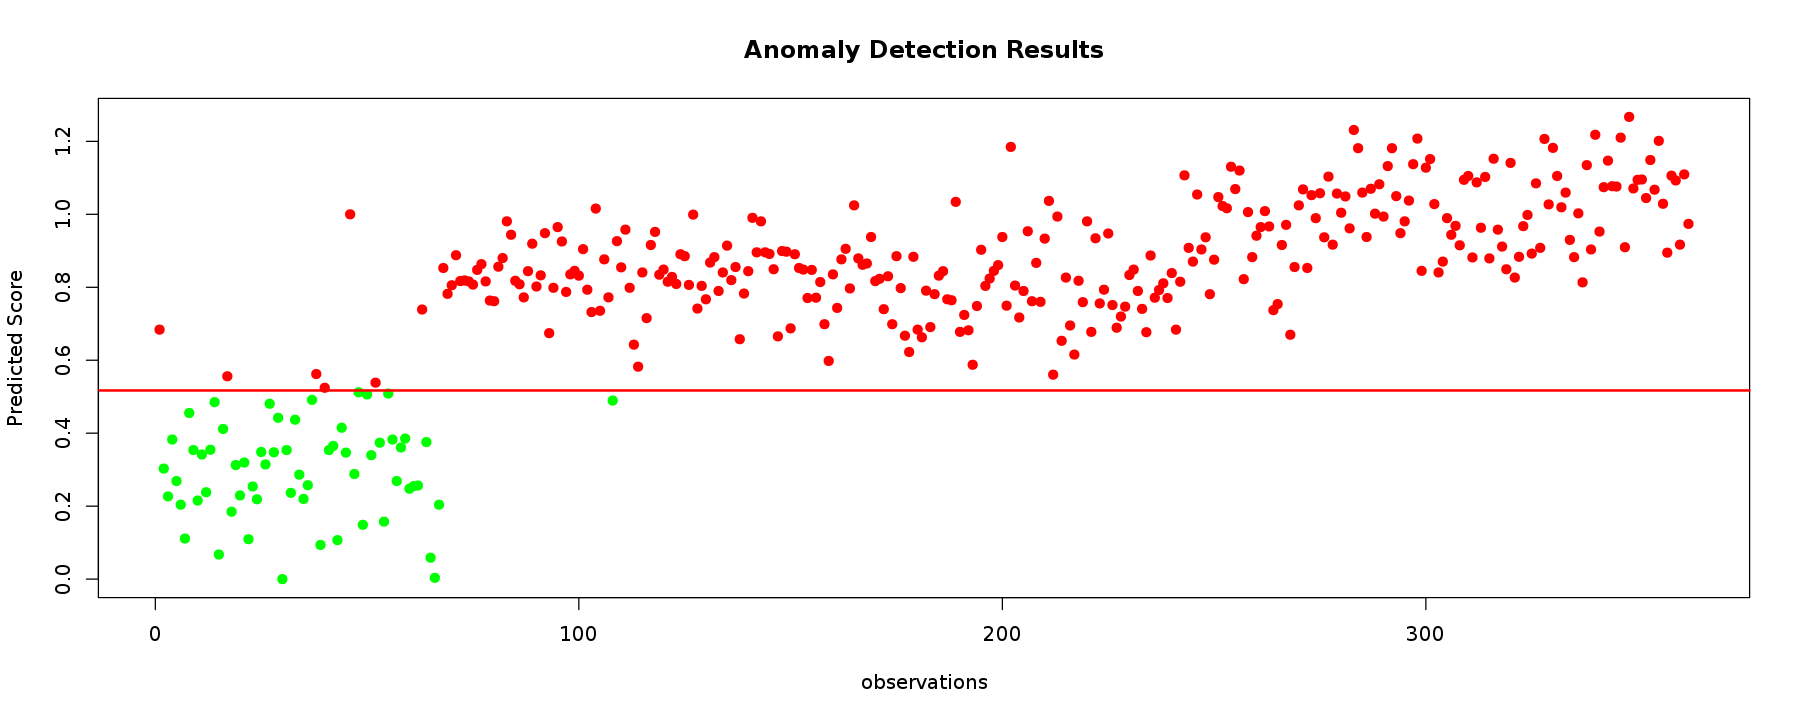

In [56]:
# Adjust plot sizes
options(repr.plot.width = 15, repr.plot.height = 6)
plot(results$predict, type = 'n', xlab='observations', ylab='Predicted Score', main = "Anomaly Detection Results")
points(results$predict, pch=19, col=ifelse(results$predict < threshold, "green", "red"))
abline(h=threshold, col='red', lwd=2)

Now, we need to close H2O cluster

In [57]:
h2o.shutdown(prompt=F)

[1] TRUE

### Session info
Below is the session info for the the packages and their versions used in this analysis. 

In [58]:
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 9 (stretch)

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] h2o_3.26.0.2 dplyr_0.8.3 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2          magrittr_1.5        tidyselect_0.2.5   
 [4] uuid_0.1-2          R6_2.4.0            rlang_0.4.1        
 [7] tools_3.3.3         htmltools_0.4.0     assertthat_0.2.1   
[10] digest_0.6.22       tibble_2.1.3        crayon_1.3.4       
[13] IRdisplay_0.7.0     purrr_0.3.3         repr_1.0.1         
[16] base64enc_0.1-3     vctrs_0.2.0         bitops_1.0-6  

### References  

[1] http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html   
[2] https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf   
[3] https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/isolation-forest/interpreting_isolation-forest.ipynb   